# 0️⃣ 기본 세팅

In [ ]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

import random
import math
from math import floor
import queue
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from collections import Counter
import torch.multiprocessing as mp
import gc

1.23.5
2.0.1+cu118


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/My Drive/🌊Ulsan_parkinglot/alphazero_models

/content/drive/My Drive/🌊Ulsan_parkinglot/alphazero_models


# 1️⃣ 몬테카를로 시뮬레이션을 이용한 중장기 스케줄링

## 기본 상수 설정

평균 입항 교통량 / 그 날의 총 처리 화물 건수 / 화물차 한 대가 들어가는데 걸리는 시간

In [ ]:
avg_traffic_per_10min = [3, 3, 3, 3, 3, 3,    # 5시
                         3, 3, 3, 3, 3, 3,    # 6시
                         8, 8, 8, 8, 8, 8,    # 7시
                         7, 7, 7, 7, 7, 7,    # 8시
                         10, 10, 10, 10, 10, 10, # 9시
                         9, 9, 9, 9, 9, 9,  # 10시
                         8, 8, 8, 8, 8, 8,  # 11시
                         6, 6, 6, 6, 6, 6,  # 12시
                         7, 7, 7, 7, 7, 7,  # 13시
                         7, 7, 7, 7, 7, 7,  # 14시
                         5, 5, 5, 5, 5, 5,  # 15시
                         3, 3, 3, 3, 3, 3,  # 16시
                         2, 2, 2, 2, 2, 2,  # 17시
                         2, 2, 2, 2, 2, 2,  # 18시
                         2, 2, 2, 2, 2, 2,  # 19시
                         1, 1, 1, 1, 1, 1,  # 20시
                         1, 1, 1, 1, 1, 1,  # 21시
                         1, 1, 1, 1, 1, 1,  # 22시
                         1, 1, 1, 1, 1, 1,  #23시
                         ]

avg_probabilities = np.array(avg_traffic_per_10min) / sum(avg_traffic_per_10min)

scheduled_cars_of_day = 700
n = 1.05

## 중장기 스케줄링

### 몬테카를로

함수 정의

In [ ]:
def generate_random_list(scheduled_cars_of_day, avg_probabilities):
    total_traffic = scheduled_cars_of_day
    probabilities = avg_probabilities
    chosen_intervals = np.random.choice(range(len(probabilities)), size=total_traffic, p=probabilities)
    generated_data = [random.uniform(i*10, (i+1)*10) for i in chosen_intervals]

    return generated_data

def balls_left_in_queue(enter_times):
    exit_times = []
    current_exit_time = 0
    total_front_cars = 0
    front_cars_distribution = []
    for i, enter_time in enumerate(enter_times):
        if current_exit_time == enter_time:
            current_exit_time = enter_time
        elif current_exit_time + n < enter_time:
            current_exit_time = enter_time
        else:
            current_exit_time += n
        exit_times.append(current_exit_time)

        front_cars = np.sum(np.array(exit_times[:i+1]) > enter_time)
        front_cars_distribution.append(front_cars)
        total_front_cars += front_cars

    return total_front_cars, front_cars_distribution

def monte_carlo_distribution(num_samples, scheduled_cars_of_day, avg_probabilities):
    total_front_cars_distribution = {}
    enter_times_storage = {}
    front_cars_distribution_storage = {}

    for _ in range(num_samples):
        enter_times = generate_random_list(scheduled_cars_of_day, avg_probabilities)
        enter_times = sorted(enter_times)
        total_front_cars, front_cars_distribution = balls_left_in_queue(enter_times)

        if total_front_cars not in total_front_cars_distribution:
            total_front_cars_distribution[total_front_cars] = 0
            enter_times_storage[total_front_cars] = []
            front_cars_distribution_storage[total_front_cars] = []

        total_front_cars_distribution[total_front_cars] += 1
        enter_times_storage[total_front_cars].append(enter_times)
        front_cars_distribution_storage[total_front_cars].append(front_cars_distribution)

    return total_front_cars_distribution, enter_times_storage, front_cars_distribution_storage

몬테 카를로 시뮬레이션 10000 번 돌리기

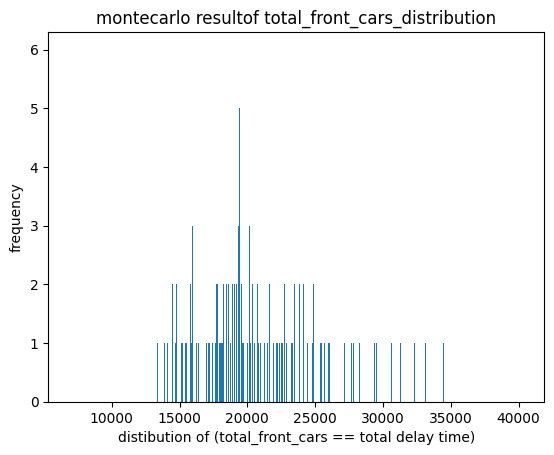

In [ ]:
total_front_cars_distribution, enter_times_storage, front_cars_distribution_storage = monte_carlo_distribution(10000, scheduled_cars_of_day, avg_probabilities)

labels = sorted(total_front_cars_distribution.keys())
values = [total_front_cars_distribution[key] for key in labels]
plt.bar(labels, values)
plt.xlabel("distibution of (total_front_cars == total delay time)")
plt.ylabel("frequency")
plt.title("montecarlo result" +"of total_front_cars_distribution")
plt.show()

몬테카를로 돌렸을 때 상위/하위 총 지연 시간 따져주기

In [ ]:
sorted_front_cars_distribution_keys = sorted(total_front_cars_distribution.keys())

print("하위 5개 총 지연 시간: \n")
for key in sorted_front_cars_distribution_keys[:5]:
    print(f"지연 시간: {key}, 빈도: {total_front_cars_distribution[key]}")
    print(f"평균 지연 시간: {key / scheduled_cars_of_day}, 빈도: {total_front_cars_distribution[key]}")

print("\n상위 5개 총 지연시간: \n")
for key in sorted_front_cars_distribution_keys[-5:][::-1]:
    print(f"지연 시간: {key}, 빈도: {total_front_cars_distribution[key]}")
    print(f"평균 지연 시간: {key / scheduled_cars_of_day}, 빈도: {total_front_cars_distribution[key]}")

하위 5개 총 지연 시간: 

지연 시간: 6975, 빈도: 1
평균 지연 시간: 9.964285714285714, 빈도: 1
지연 시간: 7412, 빈도: 1
평균 지연 시간: 10.588571428571429, 빈도: 1
지연 시간: 7443, 빈도: 1
평균 지연 시간: 10.632857142857143, 빈도: 1
지연 시간: 7683, 빈도: 1
평균 지연 시간: 10.975714285714286, 빈도: 1
지연 시간: 7950, 빈도: 1
평균 지연 시간: 11.357142857142858, 빈도: 1

상위 5개 총 지연시간: 

지연 시간: 40221, 빈도: 1
평균 지연 시간: 57.45857142857143, 빈도: 1
지연 시간: 38981, 빈도: 1
평균 지연 시간: 55.68714285714286, 빈도: 1
지연 시간: 38915, 빈도: 1
평균 지연 시간: 55.59285714285714, 빈도: 1
지연 시간: 38733, 빈도: 1
평균 지연 시간: 55.332857142857144, 빈도: 1
지연 시간: 37966, 빈도: 1
평균 지연 시간: 54.23714285714286, 빈도: 1


### 지연 시간 최소일 때

In [ ]:
min_key = sorted_front_cars_distribution_keys[0]

min_key_sample_enter_time = enter_times_storage[min_key][0]
min_key_sample_front_cars = front_cars_distribution_storage[min_key][0]

min_total_front_cars, min_front_cars_distribution = balls_left_in_queue(min_key_sample_enter_time)

지연 시간 최소일 때 상위/하위 10개 화물차 한 대 대기시간

In [ ]:
min_front_cars_distribution.sort(reverse = True)
print("지연 시간 최소일 때 상위 10개 화물차 한 대 대기시간")
print(min_front_cars_distribution[:10])
print("지연 시간 최소일 때 하위 10개 화물차 한 대 대기시간")
print(min_front_cars_distribution[-10:])

지연 시간 최소일 때 상위 10개 화물차 한 대 대기시간
[33, 32, 32, 31, 31, 31, 31, 31, 30, 30]
지연 시간 최소일 때 하위 10개 화물차 한 대 대기시간
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


지연 시간 최소일 때 입항량 분포

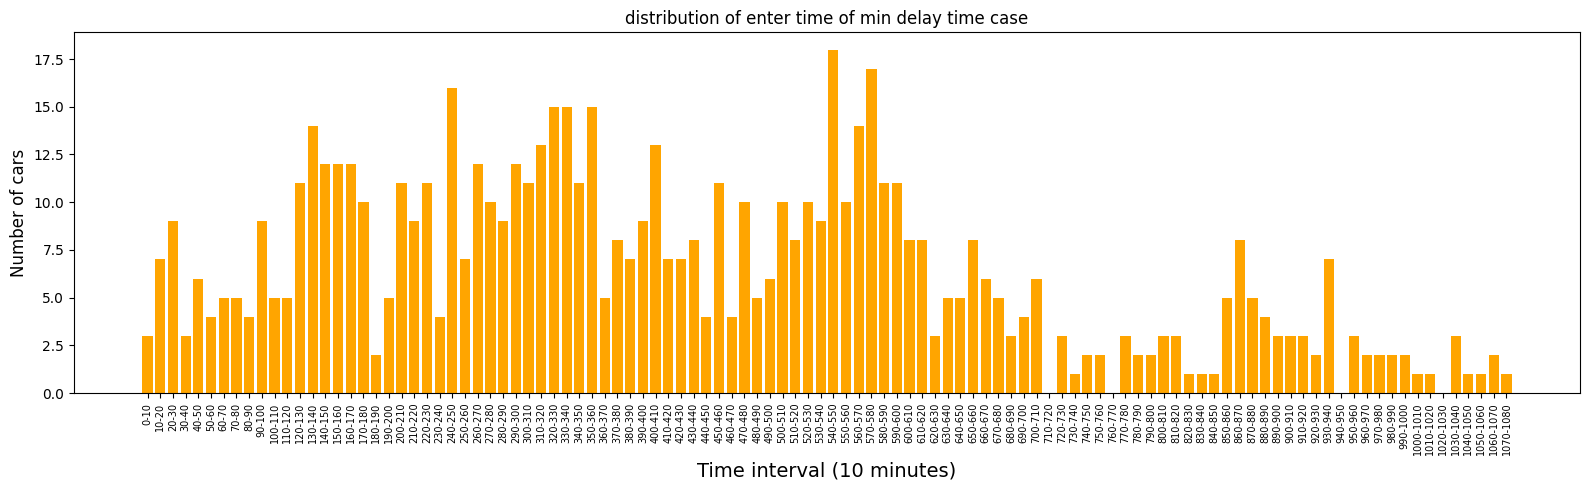

In [ ]:
bins = np.arange(0, (23-5)*6*10 + 1, 10)
min_key_sample_enter_time_counts, _ = np.histogram(min_key_sample_enter_time, bins)

time_labels = [f"{i}-{i+10}" for i in range(0, (23-5)*6*10, 10)]

plt.figure(figsize=(16,5))
plt.bar(time_labels, min_key_sample_enter_time_counts, color='orange')
plt.title("distribution of enter time of min delay time case")
plt.xlabel("Time interval (10 minutes)", fontsize=14)
plt.ylabel("Number of cars", fontsize=12)
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

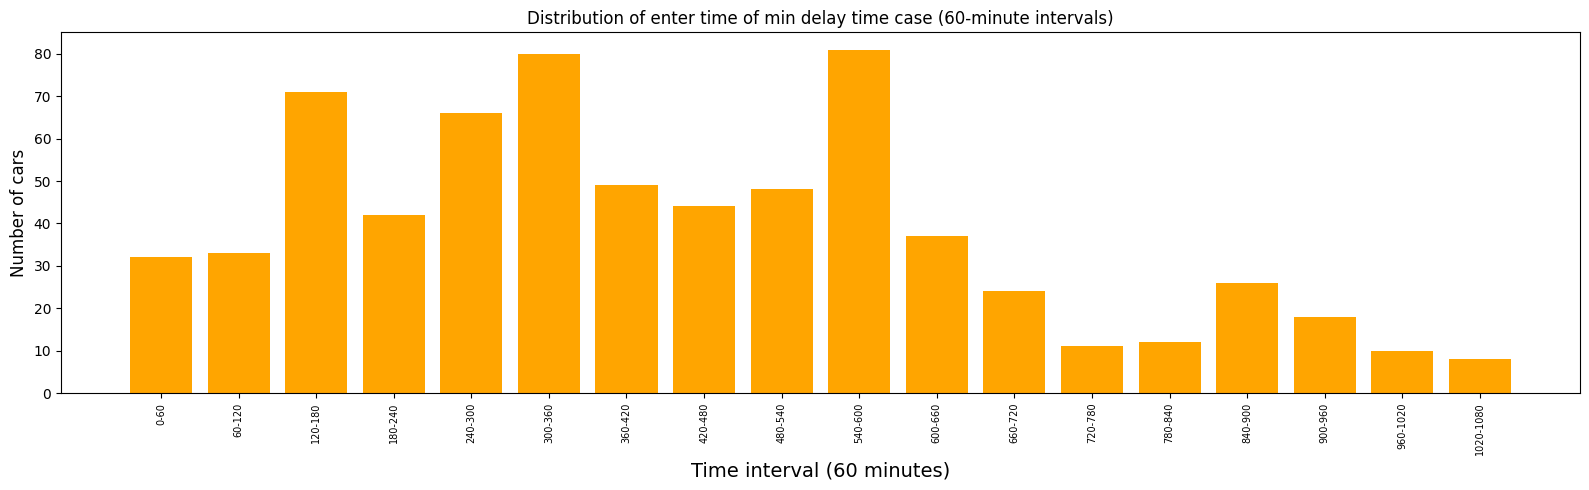

In [ ]:
bins_60min = np.arange(0, (23-5)*6*10 + 1, 60)

min_key_sample_enter_time_counts_60min, _ = np.histogram(min_key_sample_enter_time, bins_60min)

time_labels_60min = [f"{i}-{i+60}" for i in range(0, (23-5)*6*10, 60)]

plt.figure(figsize=(16,5))
plt.bar(time_labels_60min, min_key_sample_enter_time_counts_60min, color='orange')
plt.title("Distribution of enter time of min delay time case (60-minute intervals)")
plt.xlabel("Time interval (60 minutes)", fontsize=14)
plt.ylabel("Number of cars", fontsize=12)
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

지연 시간 최소일 때 화물차 한 대마다 얼마나 앞에 차량들이 밀려있는지와 관련된 시계열 분포

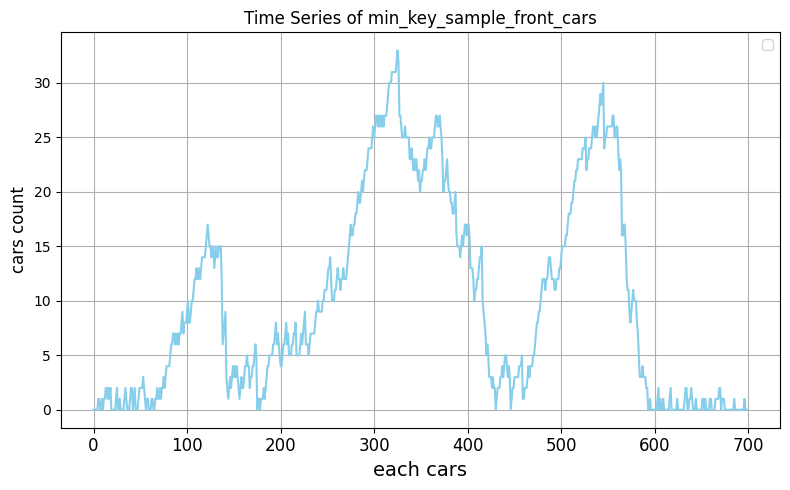

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(min_key_sample_front_cars, color='skyblue')
plt.title("Time Series of min_key_sample_front_cars")
plt.xlabel("each cars", fontsize=14)
plt.ylabel("cars count", fontsize=12)
plt.xticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2️⃣ 알파고 제로를 이용한 실시간 스케줄링

In [ ]:
print(min_key_sample_enter_time_counts)

[ 3  7  9  3  6  4  5  5  4  9  5  5 11 14 12 12 12 10  2  5 11  9 11  4
 16  7 12 10  9 12 11 13 15 15 11 15  5  8  7  9 13  7  7  8  4 11  4 10
  5  6 10  8 10  9 18 10 14 17 11 11  8  8  3  5  5  8  6  5  3  4  6  0
  3  1  2  2  0  3  2  2  3  3  1  1  1  5  8  5  4  3  3  3  2  7  0  3
  2  2  2  2  1  1  0  3  1  1  2  1]


## balls_left_in_queue

In [ ]:
def balls_left_in_queue(enter_times):
    exit_times = []
    current_exit_time = 0
    total_front_cars = 0

    enter_times = sorted(enter_times)

    for i, enter_time in enumerate(enter_times):
        if current_exit_time == enter_time:
            current_exit_time = enter_time
        elif current_exit_time + n < enter_time:
            current_exit_time = enter_time
        else:
            current_exit_time += n
        exit_times.append(current_exit_time)

        front_cars = np.sum(np.array(exit_times[:i+1]) > enter_time)
        total_front_cars += front_cars

    return total_front_cars

## monte carlo

In [ ]:
def generate_random_list(scheduled_cars_sum, probabilities):
    chosen_intervals = np.random.choice(range(len(probabilities)), size = scheduled_cars_sum, p = probabilities)
    generated_data = [random.uniform(i*10, (i+1)*10) for i in chosen_intervals]

    return generated_data

def monte_carlo_distribution(num_samples, scheduled_cars_sum, probabilities):
    total_front_cars_distribution = {}

    for _ in range(num_samples):
        enter_times = generate_random_list(scheduled_cars_sum, probabilities)
        enter_times = sorted(enter_times)
        total_front_cars = balls_left_in_queue(enter_times)

        if total_front_cars not in total_front_cars_distribution:
            total_front_cars_distribution[total_front_cars] = 0

        total_front_cars_distribution[total_front_cars] += 1

    return total_front_cars_distribution

## eta_prob

In [ ]:
eta_distribution = [2, 5, 7, 5, 5, 4, 3, 2, 1.5, 1]
eta_prob = np.array(eta_distribution) / sum(eta_distribution)

## eta_distribution_prob

In [ ]:
eta_distribution0 = [2, 5, 7, 5, 5, 4, 3, 2, 1.5, 1, 0, 0, 0]
eta_distribution1 = [0, 2, 5, 7, 5, 5, 4, 3, 2, 1.5, 1, 0, 0]
eta_distribution2 = [0, 0, 2, 5, 7, 5, 5, 4, 3, 2, 1.5, 1, 0]
eta_distribution3 = [0, 0, 0, 2, 5, 7, 5, 5, 4, 3, 2, 1.5, 1]

distributions = [eta_distribution0, eta_distribution1, eta_distribution2, eta_distribution3]
matrix = np.array(distributions)
eta_distribution = matrix.sum(axis=0)
eta_distribution_prob = np.array(eta_distribution) / sum(eta_distribution)

## MinDelay

In [ ]:
class MinDelay:
    def __init__(self, eta_distribution_prob, eta_prob):

        self.eta_distribution_prob = eta_distribution_prob
        self.eta_prob = eta_prob

        self.row_count = 50 * 2
        self.col_count = 3 + (18-7) * 6 + 9
        self.action_size = 4     # 0분, 10분, 20분, 30분 지연  (0, 1, 2, 3)

    def __repr__(self):
        return "MinDelay"

    def get_initial_state(self):
        return np.zeros((self.row_count, self.col_count))

    # 🔴
    def get_next_state(self, state, action, player, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index, car_action, test = False):

        # non_zero_indices = np.where(np.array(schedule_range) > 0)[0]
        # first_non_zero_index = non_zero_indices[0]

        # exclude_indicies = np.where(np.array(long_term_scheduled) <= 0)[0]

        # if all(x <= 0 for x in long_term_scheduled[0 : first_non_zero_index + 1]):
        #     schedule_range[first_non_zero_index] = 0
        #     first_non_zero_index += 7

        # if first_non_zero_index < 15 - 1:
        #     index_choices = [i for i in range(0, first_non_zero_index + 1) if i not in exclude_indicies]

        #     if len(index_choices) == 0:
        #         index_choices = [i for i in range(0, first_non_zero_index + 1)]

        #     origin_index = random.choice(index_choices)
        # elif first_non_zero_index < ((18-7) * 6 - 1) :
        #     if long_term_scheduled[first_non_zero_index - 15 + 1] != 0:
        #         origin_index = first_non_zero_index - 15 + 1
        #     else:
        #         index_choices = [i for i in range(first_non_zero_index - 15 + 1, first_non_zero_index + 1) if i not in exclude_indicies]

        #         if len(index_choices) == 0:
        #             index_choices = [i for i in range(first_non_zero_index - 15 + 1, first_non_zero_index + 1 + 7)]

        #         origin_index = random.choice(index_choices)
        # else:
        #     if long_term_scheduled[first_non_zero_index - 15 + 1] != 0:
        #         origin_index = first_non_zero_index - 15 + 1
        #     else:
        #         index_choices = [i for i in range(first_non_zero_index - 15 + 1, (18-7) * 6 - 1 + 1) if i not in exclude_indicies]

        #         if len(index_choices) == 0:
        #             index_choices = [first_non_zero_index + 1]

        #         origin_index = random.choice(index_choices)

        non_zero_indices = np.where(np.array(long_term_scheduled) > 0)[0]
        first_non_zero_index = non_zero_indices[0]
        origin_index = first_non_zero_index


        if sum(scheduled_cars_list) % 2 == 0:
            actioned_index = origin_index + 3 + action
        else:
            car_action = np.random.choice(range(-3, 6 + 1), size=1, p=self.eta_prob)

            a_new_row = np.where(state[:50, actioned_index + car_action] == 0)[0][0]
            state[a_new_row, actioned_index + car_action] = -1

            if test:
                b_row_indices = np.where(state[50:, actioned_index + car_action] == 0)[0][0]
                b_row = b_row_indices + 50
                state[b_row, actioned_index + car_action] = player
            else:
                b_row_indices = np.where(state[50:, origin_index + 3 + action + car_action] == 0)[0][0]
                b_row = b_row_indices + 50
                state[b_row, origin_index + 3 + action + car_action] = player

            actioned_index = None


        # schedule_range[origin_index] -= 1
        long_term_scheduled[origin_index] -= 1
        scheduled_cars_list[origin_index + 3] += 1

        return state, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index

    def get_valid_moves(self, state):
        return 1

    # 🟢
    def check_win(self, state, a_score, b_score, scheduled_cars_list, judge_num, is_self = False):
        # 심사 시작 조건
        # if (sum(scheduled_cars_list) >= 0) and (sum(scheduled_cars_list) % 4 == 0):

            # 지금까지 재조정한 화물차들의 시간대
            non_zero_indices = np.where(np.array(scheduled_cars_list) != 0)[0]

            # 지금까지 재조정한 화물차들의 (재조정 -> 스스로 이동 후) 확률 분포
            distributions = []
            for index in non_zero_indices:
                for cars_count in range(int(scheduled_cars_list[index] // 2)):
                    distributions.append([0] * (index - 3) + list(self.eta_distribution_prob) + [0] * ((3 + (18-7) * 6 + 9) - (index + 9)))
            matrix = np.array(distributions)
            eta_distribution = matrix.sum(axis=0)
            probabilities = np.array(eta_distribution) / sum(eta_distribution)

            # 하위 20, 25, 50 (몬테카를로)
            if sum(scheduled_cars_list) % 2 == 0:
                sum_scheduled_cars = sum(scheduled_cars_list) // 2
            else:
                sum_scheduled_cars = sum(scheduled_cars_list) // 2 + 1

            total_front_cars_distribution = monte_carlo_distribution(200, sum_scheduled_cars , probabilities)
            labels = sorted(total_front_cars_distribution.keys())
            values = [total_front_cars_distribution[key] for key in labels]
            cumulative_values = np.cumsum(values)

            bottom20 = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.2))[0][0]]
            bottom35 = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.35))[0][0]]
            bottom50 = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.5))[0][0]]


            # a의 총 지연 시간
            a_arr = state[:50, :]
            a_indices = np.where((a_arr == 1) | (a_arr == -1))
            a_result = [a_indices[0][np.where(a_indices[1] == col)] for col in range(a_arr.shape[1])]
            a_total_list = []
            for i in range(200):
                a_chosen_intervals = [idx for idx, arr in enumerate(a_result) for _ in arr]
                a_enter_times = [random.uniform(i*10, (i+1)*10) for i in a_chosen_intervals]
                a_total_front_cars = balls_left_in_queue(a_enter_times)
                a_total_list.append(a_total_front_cars)
            counter = Counter(a_total_list)
            top_3_common = counter.most_common(3)
            top_3_values = [item[0] for item in top_3_common]
            avg_a_total_front_cars = sum(top_3_values) / len(top_3_values)


            # b의 총 지연 시간
            b_arr = state[50:, :]
            b_indices = np.where((b_arr == 1) | (b_arr == -1))
            b_result = [b_indices[0][np.where(b_indices[1] == col)] for col in range(b_arr.shape[1])]
            b_total_list = []
            for i in range(200):
                b_chosen_intervals = [idx for idx, arr in enumerate(b_result) for _ in arr]
                b_enter_times = [random.uniform(i*10, (i+1)*10) for i in b_chosen_intervals]
                b_total_front_cars = balls_left_in_queue(b_enter_times)
                b_total_list.append(b_total_front_cars)
            counter = Counter(b_total_list)
            top_3_common = counter.most_common(3)
            top_3_values = [item[0] for item in top_3_common]
            avg_b_total_front_cars = sum(top_3_values) / len(top_3_values)


            if not is_self:
                if ((avg_a_total_front_cars > bottom20) or (avg_b_total_front_cars > bottom20)):
                    if (avg_a_total_front_cars > bottom35) and (avg_b_total_front_cars <= bottom20):
                        return 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars <= bottom20) and (avg_b_total_front_cars > bottom35):
                        return (-1)*1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                    if (avg_a_total_front_cars > bottom35) and (avg_b_total_front_cars > bottom35):
                        return 0, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars > bottom35) and (avg_b_total_front_cars < bottom35):
                        return 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars < bottom35) and (avg_b_total_front_cars > bottom35):
                        return (-1)*1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                    if (avg_a_total_front_cars < bottom35) and (avg_b_total_front_cars < bottom35):
                        return 0, False, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                # if abs(a_score - b_score) > 5 * judge_num:
                #     if avg_b_total_front_cars > avg_a_total_front_cars:
                #         return (-1) * 1, True, a_score, b_score, scheduled_cars_list, judge_num
                #     else:
                #         return 1, True, a_score, b_score, scheduled_cars_list, judge_num

                # if judge_num == 0:
                #     if avg_b_total_front_cars > avg_a_total_front_cars:
                #       return (-1) * 1, True, a_score, b_score, scheduled_cars_list, judge_num
                #     else:
                #         return 1, True, a_score, b_score, scheduled_cars_list, judge_num
            else:
                print("bottom20: ", bottom20, " bottom35: ", bottom35, "  bottom50: ", bottom50)
                print("avg_a_total_front_cars: ", avg_a_total_front_cars)
                print("avg_b_total_front_cars: ", avg_b_total_front_cars)

                # 180
                if ((sum(scheduled_cars_list) >= 1000) and ((avg_a_total_front_cars > bottom50) or (avg_b_total_front_cars > bottom50))):
                    if (avg_a_total_front_cars > bottom50) and (avg_b_total_front_cars > bottom50):
                        return 0, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars > bottom50):
                        if (avg_b_total_front_cars <= bottom35):
                            return 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                        if (avg_b_total_front_cars > bottom35):
                            return 0, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_b_total_front_cars > bottom50):
                        if (avg_a_total_front_cars <= bottom35):
                            return (-1)*1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                        if (avg_b_total_front_cars > bottom35):
                            return 0, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                # 350
                if ((sum(scheduled_cars_list) >= 1000) and ((avg_a_total_front_cars > bottom20) or (avg_b_total_front_cars > bottom20))):
                    if (avg_a_total_front_cars > bottom35) and (avg_b_total_front_cars <= bottom20):
                        print(sum(scheduled_cars_list))
                        return 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars <= bottom20) and (avg_b_total_front_cars > bottom35):
                        print(sum(scheduled_cars_list))
                        return (-1)*1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                    if (avg_a_total_front_cars > bottom35) and (avg_b_total_front_cars > bottom35):
                        print(sum(scheduled_cars_list))
                        return 0, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars > bottom35) and (avg_b_total_front_cars < bottom35):
                        print(sum(scheduled_cars_list))
                        return 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                    if (avg_a_total_front_cars < bottom35) and (avg_b_total_front_cars > bottom35):
                        print(sum(scheduled_cars_list))
                        return (-1)*1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                    if (avg_a_total_front_cars < bottom35) and (avg_b_total_front_cars < bottom35):
                        return 0, False, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

                # if abs(a_score - b_score) > 5 * judge_num:
                #     if avg_b_total_front_cars > avg_a_total_front_cars:
                #         return (-1) * 1, True, a_score, b_score, scheduled_cars_list, judge_num
                #     else:
                #         return 1, True, a_score, b_score, scheduled_cars_list, judge_num

                # if judge_num == 0:
                #     if avg_b_total_front_cars > avg_a_total_front_cars:
                #       return (-1) * 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
                #     else:
                #         return 1, True, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

            # 점수 부여
            if avg_a_total_front_cars <= bottom20:
                a_score += 5
            elif avg_a_total_front_cars <= bottom35:
                a_score += 2
            elif avg_a_total_front_cars <= bottom50:
                a_score += 0
            else:
                a_score -= 3

            if avg_b_total_front_cars <= bottom20:
                b_score += 5
            elif avg_b_total_front_cars <= bottom35:
                b_score += 2
            elif avg_b_total_front_cars <= bottom50:
                b_score += 0
            else:
                b_score -= 3

            # 남은 심사 횟수 1 감소
            judge_num -= 1

            # 어차피 terminated 아니면 value 값 무시됨
            if a_score > b_score:
                    return (-1) * 1, False, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
            else:
                return 1, False, a_score, b_score, scheduled_cars_list, judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

        # else:
        #     # return 0, False, a_score, b_score, scheduled_cars_list, judge_num
        #     if a_score > b_score:
        #             return (-1) * a_score, False, a_score, b_score, scheduled_cars_list, judge_num
        #     else:
        #         return b_score, False, a_score, b_score, scheduled_cars_list, judge_num

    # 🟢
    def get_value_and_terminated(self, state, action, a_score, b_score, scheduled_cars_list, judge_num):
        value = 0
        if ((sum(scheduled_cars_list) >= 0) and sum(scheduled_cars_list) % 2 == 0):
            value, terminated, a_score, b_score, scheduled_cars_list, judge_num, _, _, _, _, _  = self.check_win(state, a_score, b_score, scheduled_cars_list, judge_num)
            if terminated :
                return value, True, a_score, b_score, scheduled_cars_list, judge_num
        return value, False, a_score, b_score, scheduled_cars_list, judge_num

    def self_get_value_and_terminated(self, state, action, a_score, b_score, scheduled_cars_list, self_judge_num):
        value = 0
        if (sum(scheduled_cars_list) % 2 == 0):
            value, terminated, a_score, b_score, scheduled_cars_list, self_judge_num, _, _, _, _, _ = self.check_win(state, a_score, b_score, scheduled_cars_list, self_judge_num, is_self = True)
            if terminated :
                return value, True, a_score, b_score, scheduled_cars_list, self_judge_num
        return value, False, a_score, b_score, scheduled_cars_list, self_judge_num

    def test_get_value_and_terminated(self, state, action, a_score, b_score, scheduled_cars_list, test_judge_num):
        value = 0
        if True :
            value, terminated, a_score, b_score, scheduled_cars_list, test_judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars\
             = self.check_win(state, a_score, b_score, scheduled_cars_list, test_judge_num, is_self = True)
            if terminated :
                return value, True, a_score, b_score, scheduled_cars_list, test_judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars
        return value, False, a_score, b_score, scheduled_cars_list, test_judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars

    def get_opponent(self, player):
        return (-1) *  player

    def get_opponent_value(self, value):
        return (-1) *  value

    def change_perspective(self, state, player):
        return state * player

    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)

        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)

        return encoded_state

## Resnet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()

        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.col_count, game.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.col_count, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x


## Node

In [ ]:
class Node:
    def __init__(self, game, args, state, long_term_scheduled, schedule_range, scheduled_cars_list, a_score, b_score, judge_num, actioned_index, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

        self.long_term_scheduled = long_term_scheduled
        self.schedule_range = schedule_range
        self.scheduled_cars_list = scheduled_cars_list
        self.a_score = a_score
        self.b_score = b_score
        self.judge_num = judge_num
        self.actioned_index = actioned_index

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    # 🔴
    def expand(self, policy, origin_long_term_scheduled, origin_schedule_range, origin_scheduled_cars_list, a_score, b_score, judge_num, origin_actioned_index):

        car_action = np.random.choice(range(-3, 6 + 1), size=1, p=self.game.eta_prob)

        for action, prob in enumerate(policy):
            long_term_scheduled = copy.deepcopy(origin_long_term_scheduled)
            schedule_range = copy.deepcopy(origin_schedule_range)
            scheduled_cars_list = copy.deepcopy(origin_scheduled_cars_list)

            if prob > 0:
                child_state = self.state.copy()

                child_state, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index \
                 = self.game.get_next_state(child_state, action, 1, long_term_scheduled, schedule_range, scheduled_cars_list, origin_actioned_index, car_action)
                # 🟡
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, long_term_scheduled, schedule_range, scheduled_cars_list, a_score, b_score, judge_num, actioned_index, self, action, prob)
                self.children.append(child)

        return child

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)

## MCTS

In [ ]:
class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state, origin_long_term_scheduled, origin_schedule_range, origin_scheduled_cars_list, origin_judge_num, origin_actioned_index, origin_a_score = 0, origin_b_score = 0):
        root = Node(self.game, self.args, state, origin_long_term_scheduled, origin_schedule_range, origin_scheduled_cars_list, origin_a_score, origin_b_score, origin_judge_num, origin_actioned_index, visit_count=1)

        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)

        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)

        long_term_scheduled = copy.deepcopy(origin_long_term_scheduled)
        schedule_range = copy.deepcopy(origin_schedule_range)
        scheduled_cars_list = copy.deepcopy(origin_scheduled_cars_list)
        a_score = origin_a_score
        b_score = origin_b_score
        judge_num = origin_judge_num
        actioned_index = origin_actioned_index

        # 🔴
        child = root.expand(policy, long_term_scheduled, schedule_range, scheduled_cars_list, a_score, b_score, judge_num, actioned_index)

        for search in range(self.args['num_searches']):
            node = root

            long_term_scheduled = copy.deepcopy(origin_long_term_scheduled)
            schedule_range = copy.deepcopy(origin_schedule_range)
            scheduled_cars_list = copy.deepcopy(origin_scheduled_cars_list)
            a_score = origin_a_score
            b_score = origin_b_score
            judge_num = origin_judge_num

            while node.is_fully_expanded():
                node = node.select()

            long_term_scheduled = node.long_term_scheduled
            schedule_range = node.schedule_range
            scheduled_cars_list = node.scheduled_cars_list
            a_score = node.a_score
            b_score = node.b_score
            judge_num = node.judge_num

            # 🟢

            value, is_terminal, a_score, b_score, scheduled_cars_list, judge_num \
            = self.game.get_value_and_terminated(node.state, node.action_taken, a_score, b_score, scheduled_cars_list, judge_num)
            value = self.game.get_opponent_value(value)

            # if (is_terminal):
                # print("⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐")

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)

                value = value.item()

                # 🔴
                child = node.expand(policy, long_term_scheduled, schedule_range, scheduled_cars_list, a_score, b_score, judge_num, node.actioned_index)

            node.backpropagate(value)


        # ⭐⭐⭐
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

## alphagozero

In [ ]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, self_judge_num):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.long_term_scheduled = copy.deepcopy(long_term_scheduled)
        self.schedule_range = copy.deepcopy(schedule_range)
        self.scheduled_cars_list = copy.deepcopy(scheduled_cars_list)
        self.judge_num = judge_num
        self.self_judge_num = self_judge_num
        self.mcts = MCTS(game, args, model)

    def selfPlay(self, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, self_judge_num, a_score = 0, b_score = 0):
        memory = []
        player = 1
        state = self.game.get_initial_state()

        for i, counts in enumerate(scheduled_cars_list):
            for count in range(int(counts / 2)):
                cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=self.game.eta_prob)

                action = random.randint(0, 3)
                row = np.where(state[:50, i  + action + cars_action] == 0)[0][0]
                state[row, i  + action + cars_action] = -1

                action = random.randint(0, 3)
                row= np.where(state[50:, i  + action + cars_action] == 0)[0][0] + 50
                state[row, i + action + cars_action] = 1

        # 마지막으로 b가 둠
        # a가 초수를 둬야 하는 판으로 state 들어감

        actioned_index = None

        while True:
            # 🟡
            neutral_state = self.game.change_perspective(state, player)

            # search
            action_probs = self.mcts.search(neutral_state, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, actioned_index)

            memory.append((neutral_state, action_probs, player))

            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            temperature_action_probs /= sum(temperature_action_probs)   # Divide temperature_action_probs with its sum in case of an error
            action = np.random.choice(self.game.action_size, p=temperature_action_probs)

            # 🔴
            car_action = np.random.choice(range(-3, 6 + 1), size=1, p=self.game.eta_prob)

            state, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index \
             = self.game.get_next_state(state, action, player, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index, car_action)

            # 🟢
            value, is_terminal, a_score, b_score, scheduled_cars_list, self_judge_num \
            = self.game.self_get_value_and_terminated(state, action, a_score, b_score, scheduled_cars_list, self_judge_num)

            print("🧠 moved_cars: ", sum(scheduled_cars_list) - sum(self.scheduled_cars_list))
            print("🧠 action", action)
            print("🧠 a_score: ", a_score, "   🧠 b_score", b_score)

            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                # 판이 이런 상태일 때(게임 중 어떤 상태), 이 수를 택하면, 결과적으로 진다 / 이긴다
                return returnMemory

            player = self.game.get_opponent(player)
            print("🧠 is_terminal:", is_terminal)
            print()

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])] # Change to memory[batchIdx:batchIdx+self.args['batch_size']] in case of an error
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay(self.long_term_scheduled, self.schedule_range, self.scheduled_cars_list, self.judge_num, self.self_judge_num)

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            return self.model.state_dict(), self.optimizer.state_dict(), memory

## ⭐ training_demo

In [ ]:
# min_key_sample_enter_time_counts[min_key_sample_enter_time_counts == 0] = 1
# long_term_scheduled = list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]

# schedule_range = []

# for i, cars in enumerate(long_term_scheduled):
#     if i < 15:
#         schedule_range.append(math.ceil(sum(long_term_scheduled[0 : i]) / 15))
#     elif i < 6 * (18-7):
#         schedule_range.append(math.ceil(sum(long_term_scheduled[i - 15 + 1: i + 1]) / 15))

# for i in range( 6*(18-7) - 15 + 1, 6*(18-7)):
#     schedule_range.append(math.ceil(sum(long_term_scheduled[i: 6*(18-7)]) / 15))

# # =============================================================

# # 📌📌 118은 sum(scheduled_cars_list)
# # 📌📌 심사 횟수와 judge_num

# initial_index = 14

# valid_indices = [i for i, val in enumerate(long_term_scheduled[:initial_index]) if val > 0]

# selected_indices = []
# for _ in range(sum(schedule_range[:initial_index])):
#     idx = np.random.choice(valid_indices)
#     while long_term_scheduled[idx] <= 0:
#         valid_indices.remove(idx)
#         idx = np.random.choice(valid_indices)
#     long_term_scheduled[idx] -= 1
#     selected_indices.append(idx)

# sorted_indices = sorted(selected_indices)
# counts = Counter(sorted_indices)
# count_list = [counts[element] for element in counts]

# long_term_scheduled = list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]
# for i, value in enumerate(count_list):
#     long_term_scheduled [i] -= value
# scheduled_cars_list = [0] * 3 + count_list + [0] * (len(long_term_scheduled) - len(count_list)) + [0] * 9
# judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 1 + 1
# self_judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 4 + 1
# schedule_range[0:initial_index] = [0] * initial_index

# long_term_scheduled = list(2 * np.array(long_term_scheduled))
# schedule_range = list(2 * np.array(schedule_range))
# scheduled_cars_list = list(2 * np.array(scheduled_cars_list))

# # ===============================================================


# game = MinDelay(eta_distribution_prob, eta_prob)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ResNet(game, 9, 128, device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# args = {
#     'C': 2,
#     'num_iterations': 1,          # 몇 번 모델을 훈련할꺼냐
#     'num_selfPlay_iterations': 2, # 자기대국 몇 번 할꺼냐 = 훈련 샘플의 수
#     'num_searches': 50,          # 얼만큼(몇 노드만큼) 더 내다볼거냐
#     'num_epochs': 1,              # 몇 에포크 돌릴꺼냐
#     'num_parallel_games': 100,
#     'batch_size': 128,
#     'temperature': 1.25,
#     'dirichlet_epsilon': 0.25,
#     'dirichlet_alpha': 0.3
# }

# alphaZero = AlphaZero(model, optimizer, game, args, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, self_judge_num)
# model_state_dict, optimizer_state_dict, memory = alphaZero.learn()

In [ ]:
# print(list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1])
# print()
# print(count_list)
# print()
# print(scheduled_cars_list)
# print(sum(scheduled_cars_list))
# print(len(scheduled_cars_list))
# print()
# print(long_term_scheduled)
# print(sum(long_term_scheduled))
# print(len(long_term_scheduled))

In [ ]:
# long_term_scheduled = [a - b for a, b in zip(long_term_scheduled, count_list)]
# print(long_term_scheduled)

## MCTSParellel

In [ ]:
class MCTSParallel:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, states, spGames, origin_long_term_scheduleds, origin_schedule_ranges, origin_scheduled_cars_lists, origin_judge_nums, origin_actioned_indexes, origin_a_scores = 0, origin_b_scores = 0):
        policy, _ = self.model(torch.tensor(self.game.get_encoded_state(states), device=self.model.device))
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size, size=policy.shape[0])

        for i, spg in enumerate(spGames):
            spg_policy = policy[i]
            valid_moves = self.game.get_valid_moves(states[i])
            spg_policy *= valid_moves
            spg_policy += 0.2
            spg_policy /= np.sum(spg_policy)
            print("mcts policy: ", spg_policy)

            state = copy.deepcopy(states[i])
            origin_long_term_scheduled = origin_long_term_scheduleds[i]
            origin_schedule_range = origin_schedule_ranges[i]
            origin_scheduled_cars_list = origin_scheduled_cars_lists[i]
            origin_a_score = 0
            origin_b_score = 0
            origin_judge_num = origin_judge_nums[i]
            origin_actioned_index = origin_actioned_indexes[i]

            for root_index in range(len(spg.root)):
                spg.root[root_index] = Node(self.game, self.args, state, origin_long_term_scheduled, origin_schedule_range, origin_scheduled_cars_list, \
                                origin_a_score, origin_b_score, origin_judge_num, origin_actioned_index, visit_count=1)

                long_term_scheduled = copy.deepcopy(origin_long_term_scheduled)
                schedule_range = copy.deepcopy(origin_schedule_range)
                scheduled_cars_list = copy.deepcopy(origin_scheduled_cars_list)
                a_score = origin_a_score
                b_score = origin_b_score
                judge_num = origin_judge_num
                actioned_index = origin_actioned_index

                spg.root[root_index].expand(spg_policy, long_term_scheduled, schedule_range, scheduled_cars_list, a_score, b_score, judge_num, actioned_index)


        for root_index in range(len(spGames[0].root)):
            for search in range(self.args['num_searches']):
                for spg in spGames:
                    spg.node = None
                    node = spg.root[root_index]

                    while node.is_fully_expanded():
                        node = node.select()

                    long_term_scheduled = node.long_term_scheduled
                    schedule_range = node.schedule_range
                    scheduled_cars_list = node.scheduled_cars_list
                    a_score = node.a_score
                    b_score = node.b_score
                    judge_num = node.judge_num
                    actioned_index = node.actioned_index

                    value, is_terminal, a_score, b_score, scheduled_cars_list, judge_num \
                    = self.game.get_value_and_terminated(node.state, node.action_taken, a_score, b_score, scheduled_cars_list, judge_num)
                    value = self.game.get_opponent_value(value)

                    if is_terminal:
                        node.backpropagate(value)

                    else:
                        spg.node = node

                expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

                # 나의 턴의 value 반환
                # 💎 => 게임이 끝나지 않았으면 value 업데이트 하여 < 확장 >, < 역전파 >

                # 병렬로 한번에 고려할 game 경우의 수에 대해 states 생성,
                # 병렬로 states의 policy와 value값 반환 (value 업데이트)

                if len(expandable_spGames) > 0:
                    states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])

                    policy, value = self.model(
                        torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
                    )
                    policy = torch.softmax(policy, axis=1).cpu().numpy()
                    value = value.cpu().numpy()

                # 각각의 game에 대해 확장, 역전파 수행
                for i, mappingIdx in enumerate(expandable_spGames):
                    # 끝나지 않은 게임의 node는 반드시 존재 (해당 게임의 선택된 best_child)
                    node = spGames[mappingIdx].node
                    spg_policy, spg_value = policy[i], value[i]

                    valid_moves = self.game.get_valid_moves(node.state)
                    spg_policy *= valid_moves
                    spg_policy /= np.sum(spg_policy)

                    node.expand(spg_policy, long_term_scheduled, schedule_range, scheduled_cars_list, a_score, b_score, judge_num, actioned_index)
                    node.backpropagate(spg_value)

## AlphaZeroParallel

In [ ]:
class SPG:
    def __init__(self, game, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, self_judge_num, actioned_index, a_score = 0, b_score = 0, size = 1):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = [None] * size
        self.node = None

        self.long_term_scheduled = copy.deepcopy(long_term_scheduled)
        self.schedule_range = copy.deepcopy(schedule_range)
        self.scheduled_cars_list = copy.deepcopy(scheduled_cars_list)
        self.judge_num = judge_num
        self.self_judge_num = self_judge_num
        self.actioned_index = copy.deepcopy(actioned_index)
        self.a_score = a_score
        self.b_score = b_score

        for i, counts in enumerate(scheduled_cars_list):
            for count in range(int(counts / 2)):
                cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=game.eta_prob)
                action = random.randint(0, 3)

                row = np.where(self.state[:50, i  + action + cars_action] == 0)[0][0]
                self.state[row, i  + action + cars_action] = -1

                row= np.where(self.state[50:, i  + action + cars_action] == 0)[0][0] + 50
                self.state[row, i + action + cars_action] = 1

        _, terminated, _, _, _, _ = game.check_win(self.state, self.a_score, self.b_score, self.scheduled_cars_list, self.judge_num)

        while terminated == True:
            self.state = game.get_initial_state()
            for i, counts in enumerate(scheduled_cars_list):
                for count in range(int(counts / 2)):
                    cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=game.eta_prob)
                    action = random.randint(0, 3)

                    row = np.where(self.state[:50, i  + action + cars_action] == 0)[0][0]
                    self.state[row, i  + action + cars_action] = -1

                    row= np.where(self.state[50:, i  + action + cars_action] == 0)[0][0] + 50
                    self.state[row, i + action + cars_action] = 1

            _, terminated, _, _, _, _ = game.check_win(self.state, self.a_score, self.b_score, self.scheduled_cars_list, self.judge_num)


class AlphaZeroParallel:
    def __init__(self, model, optimizer, game, args, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, self_judge_num):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args

        self.long_term_scheduled = copy.deepcopy(long_term_scheduled)
        self.schedule_range = copy.deepcopy(schedule_range)
        self.scheduled_cars_list = copy.deepcopy(scheduled_cars_list)
        self.judge_num = judge_num
        self.self_judge_num = self_judge_num

        self.mcts = MCTSParallel(game, args, model)

    def selfPlay(self, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, self_judge_num, a_score = 0, b_score = 0):
        return_memory = []
        player = 1
        spGames = [SPG(self.game, self.long_term_scheduled, self.schedule_range, self.scheduled_cars_list, self.judge_num, \
                       self.self_judge_num, actioned_index = None, a_score = 0, b_score = 0) for spg in range(self.args['num_parallel_games'])]

        num_cars = 0
        while len(spGames) > 0:
            # 병렬로 mcts 수행 (계속 번갈아가며 수행)
            states = np.stack([spg.state for spg in spGames])
            long_term_scheduleds = np.stack([spg.long_term_scheduled for spg in spGames])
            schedule_ranges = np.stack([spg.schedule_range for spg in spGames])
            scheduled_cars_lists = np.stack([spg.scheduled_cars_list for spg in spGames])
            judge_nums = [spg.judge_num for spg in spGames]
            self_judge_nums = [spg.self_judge_num for spg in spGames]
            actioned_indexs = [spg.actioned_index for spg in spGames]

            neutral_states = self.game.change_perspective(states, player)

            self.mcts.search(neutral_states, spGames, long_term_scheduleds, schedule_ranges, scheduled_cars_lists, judge_nums, actioned_indexs)

            # print("⭐⭐⭐⭐⭐search 완⭐⭐⭐⭐⭐")

            # 각각의 게임 하나에 대해 수행
            for i in range(len(spGames))[::-1]:
                spg = spGames[i]

                # 행동 확률 계산:
                action_probs = np.zeros(self.game.action_size)

                for root_index in range(len(spg.root)):
                    for child in spg.root[root_index].children:
                        action_probs[child.action_taken] += child.visit_count

                action_probs /= np.sum(action_probs)
                print("action_probs: ", action_probs)


                # (상태, 그 상태일 때 확률 분포, player)
                spg.memory.append((spg.root[0].state, action_probs, player))

                #  행동 확률 분포를 기반으로 하나의 행동을 선택합니다.
                temperature_action_probs = action_probs ** (1 / self.args['temperature'])
                temperature_action_probs /= sum(temperature_action_probs)
                action = np.random.choice(self.game.action_size, p=temperature_action_probs) # Divide temperature_action_probs with its sum in case of an error

                # 상태 업데이트

                car_action = np.random.choice(range(-3, 6 + 1), size=1, p=self.game.eta_prob)

                spg.state, spg.long_term_scheduled, spg.schedule_range, spg.scheduled_cars_list, spg.actioned_index \
                = self.game.get_next_state(spg.state, action, player, spg.long_term_scheduled, spg.schedule_range, spg.scheduled_cars_list, spg.actioned_index, car_action)

                # 게임 종료 여부 확인

                value, is_terminal, spg.a_score, spg.b_score, spg.scheduled_cars_list, spg.self_judge_num \
                = self.game.self_get_value_and_terminated(spg.state, action, spg.a_score, spg.b_score, spg.scheduled_cars_list, spg.self_judge_num)

                a_sub_array = spg.state[:50]
                b_sub_array = spg.state[50:]

                a_mask = (a_sub_array != 1) & (a_sub_array != -1)
                b_mask = (b_sub_array != 1) & (b_sub_array != -1)

                a_count = 50 - a_mask.sum(axis=0)
                b_count = 50 - b_mask.sum(axis=0)

                print("a_count")
                print(a_count)
                print("b_count")
                print(b_count)

                if is_terminal:
                    for hist_neutral_state, hist_action_probs, hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append((
                            self.game.get_encoded_state(hist_neutral_state),
                            hist_action_probs,
                            hist_outcome
                        ))
                    del spGames[i]

                print(i, "번째 게임판")
                print("a_score", spg.a_score, "   b_score", spg.b_score)

            num_cars += 1
            print("🧠 모든 게임에 대해 a, b 모두 합해서", sum(spg.scheduled_cars_list) , "만큼 자동차 두었음")
            print()
            player = self.game.get_opponent(player)

            torch.cuda.empty_cache()

        return return_memory

    def train(self, memory):
        # 데이터 섞기
        random.shuffle(memory)

        # 배치 학습
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            # 현재 배치의 데이터를 추출
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])] # Change to memory[batchIdx:batchIdx+self.args['batch_size']] in case of an error
            state, policy_targets, value_targets = zip(*sample)

            # 데이터 변환
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            # 모델 예측
            out_policy, out_value = self.model(state)

            # 손실 계산
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            # 역전파 및 업데이트
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    # 전체 프로세스 지정
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            print()
            print("📌   📌    📌    📌    📌   📌")
            print("훈련 횟수: ", iteration + 1)
            print("📌   📌    📌    📌    📌    📌")
            print()
            memory = []

            # 지정된 횟수(num_selfPlay_iterations)만큼 자기대국을 수행하여 기억(memory)을 수집
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
                print()
                print("🌟   🌟    🌟    🌟    🌟    🌟")
                print("자기대국 횟수: ", selfPlay_iteration + 1)
                print("🌟   🌟    🌟    🌟    🌟    🌟")
                print()
                memory += self.selfPlay(self.long_term_scheduled, self.schedule_range, self.scheduled_cars_list, self.judge_num, self.self_judge_num, a_score = 0, b_score = 0)

            # 기억을 모두 수집한 후, 모델을 훈련 모드로 전환(train())하고 지정된 에폭(num_epochs) 수만큼 모델을 학습
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            model_path = "model_{}.pt".format('current')
            optimizer_path = "optimizer_{}.pt".format('current')

            torch.save(self.model.state_dict(), model_path)
            torch.save(self.optimizer.state_dict(), optimizer_path)

        return self.model.state_dict(), self.optimizer.state_dict()

            # model_path = "/content/drive/My Drive/🌊Ulsan_parkinglot/alphazero_models/model_{}_{}.pt".format(iteration, self.game)
            # optimizer_path = "/content/drive/My Drive/🌊Ulsan_parkinglot/alphazero_models/optimizer_{}_{}.pt".format(iteration, self.game)

            # torch.save(self.model.state_dict(), model_path)
            # torch.save(self.optimizer.state_dict(), optimizer_path)

# ⭐ training

In [ ]:
min_key_sample_enter_time_counts[min_key_sample_enter_time_counts == 0] = 1
long_term_scheduled = list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]

schedule_range = []

for i, cars in enumerate(long_term_scheduled):
    if i < 15:
        schedule_range.append(math.ceil(sum(long_term_scheduled[0 : i]) / 15))
    elif i < 6 * (18-7):
        schedule_range.append(math.ceil(sum(long_term_scheduled[i - 15 + 1: i + 1]) / 15))

for i in range( 6*(18-7) - 15 + 1, 6*(18-7)):
    schedule_range.append(math.ceil(sum(long_term_scheduled[i: 6*(18-7)]) / 15))

# =============================================================

# 📌📌 심사 횟수와 judge_num

initial_index = 15

valid_indices = [i for i, val in enumerate(long_term_scheduled[:initial_index]) if val > 0]

selected_indices = []
for _ in range(sum(schedule_range[:initial_index])):
    idx = np.random.choice(valid_indices)
    while long_term_scheduled[idx] <= 0:
        valid_indices.remove(idx)
        idx = np.random.choice(valid_indices)
    long_term_scheduled[idx] -= 1
    selected_indices.append(idx)

sorted_indices = sorted(selected_indices)
counts = Counter(sorted_indices)
count_list = [counts[element] for element in counts]

long_term_scheduled = list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]
for i, value in enumerate(count_list):
    long_term_scheduled [i] -= value
scheduled_cars_list = [0] * 3 + count_list + [0] * (len(long_term_scheduled) - len(count_list)) + [0] * 9
schedule_range[0:initial_index] = [0] * initial_index

# count_list = []
# scheduled_cars_list = [0] * 3 + count_list + [0] * (len(long_term_scheduled) - len(count_list)) + [0] * 9

initial_long_term_scheduled = copy.deepcopy(list(2 * np.array(long_term_scheduled)))
initial_schedule_range = copy.deepcopy(list(2 * np.array(schedule_range)))
initial_scheduled_cars_list = copy.deepcopy(list(2 * np.array(scheduled_cars_list)))

In [ ]:
# 기존 중장기 스케줄링된 결과
print(list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1])
print(sum((list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1])))
print()
print(count_list)
print()
# 초기 화물차들을 조금 둔 채로 시작
print(initial_scheduled_cars_list)
print(sum(initial_scheduled_cars_list))
print(len(initial_scheduled_cars_list))
print()
# 초기 화물차들을 조금 둔 후 중장기 스케줄링된 결과에서 남은 화물차들
#  == 앞으로 실시간 스케줄링 해야 할 화물차들
print(initial_long_term_scheduled)
print(sum(initial_long_term_scheduled))
print(len(initial_long_term_scheduled))
print()
# 조정 대상 화물차들 indicator
print(initial_schedule_range)
print(sum(initial_schedule_range))
print(len(initial_schedule_range))

[8, 12, 11, 17, 9, 13, 6, 8, 10, 5, 10, 7, 15, 12, 9, 11, 8, 12, 13, 9, 3, 15, 11, 8, 7, 9, 7, 12, 6, 8, 11, 14, 8, 9, 11, 9, 10, 7, 10, 12, 5, 9, 12, 12, 16, 9, 5, 6, 11, 13, 9, 6, 10, 2, 2, 3, 5, 2, 1, 4, 5, 1, 1, 2, 4, 7]

[8, 9, 8, 8, 4, 12, 5, 8, 9, 5, 10, 5, 7, 9, 8, 9, 5, 12, 4, 8, 3, 10, 4, 6, 7]

[0, 0, 0, 16, 18, 16, 16, 8, 24, 10, 16, 18, 10, 20, 10, 14, 18, 16, 18, 10, 24, 8, 16, 6, 20, 8, 12, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
366
78

[0, 6, 6, 18, 10, 2, 2, 0, 2, 0, 0, 4, 16, 6, 2, 4, 6, 0, 18, 2, 0, 10, 14, 4, 0, 18, 14, 24, 12, 16, 22, 28, 16, 18, 22, 18, 20, 14, 20, 24, 10, 18, 24, 24, 32, 18, 10, 12, 22, 26, 18, 12, 20, 4, 4, 6, 10, 4, 2, 8, 10, 2, 2, 4, 8, 14]
742
66

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 22, 20, 20, 20, 20, 20, 20, 2

### training

In [ ]:
game = MinDelay(eta_distribution_prob, eta_prob)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 128, device)

In [ ]:
model.load_state_dict(torch.load("model_current.pt"))

<All keys matched successfully>

In [ ]:
judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 2 + 1
self_judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 2 + 1

game = MinDelay(eta_distribution_prob, eta_prob)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_iterations': 10,              # 몇 번 모델을 훈련할꺼냐
    'num_selfPlay_iterations': 1,    # 자기대국 몇 번 할꺼냐 ... 훈련 샘플의 수
    'num_searches': 50,               # 얼만큼(몇 노드만큼) 더 내다볼거냐 .... (2~3수 앞까지 내다보자!)
    'num_epochs': 50,                  # 몇 에포크 돌릴꺼냐
    'num_parallel_games': 1,          # 한 번에 몇 개씩 병렬로 게임 시행
    'batch_size': 10,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

# 게임이 얼마나 깊게 진행되느냐도 훈련 샘플의 수와 관련 있음

# args = {
#     'C': 2,
#     'num_iterations': 8,            # 몇 번 모델을 훈련할꺼냐
#     'num_selfPlay_iterations': 500, # 자기대국 몇 번 할꺼냐 = 훈련 샘플의 수
#     'num_searches': 600,             # 얼만큼(몇 노드만큼) 더 내다볼거냐
#     'num_epochs': 4,                # 몇 에포크 돌릴꺼냐
#     'num_parallel_games': 100,      # 한 번에 몇 개씩 병렬로 게임 시행
#     'batch_size': 128,
#     'temperature': 1.25,
#     'dirichlet_epsilon': 0.25,
#     'dirichlet_alpha': 0.3
# }

alphaZero = AlphaZeroParallel(model, optimizer, game, args, initial_long_term_scheduled, initial_schedule_range, initial_scheduled_cars_list, judge_num, self_judge_num)
model_state_dict, optimizer_state_dict = alphaZero.learn()

In [ ]:
# model_path = "model_{}.pt".format('0821')
# optimizer_path = "optimizer_{}.pt".format('0821')

# torch.save(model.state_dict(), model_path)
# torch.save(optimizer.state_dict(), optimizer_path)

# 4️⃣ 알파고 제로 성능 평가

## 성능 평가 기본 세팅

In [ ]:
min_key_sample_enter_time_counts[min_key_sample_enter_time_counts == 0] = 1
long_term_scheduled = list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]

schedule_range = []

for i, cars in enumerate(long_term_scheduled):
    if i < 15:
        schedule_range.append(math.ceil(sum(long_term_scheduled[0 : i]) / 15))
    elif i < 6 * (18-7):
        schedule_range.append(math.ceil(sum(long_term_scheduled[i - 15 + 1: i + 1]) / 15))

for i in range( 6*(18-7) - 15 + 1, 6*(18-7)):
    schedule_range.append(math.ceil(sum(long_term_scheduled[i: 6*(18-7)]) / 15))

# =============================================================

# 📌📌 심사 횟수와 judge_num

initial_index = 15

while True :
    valid_indices = [i for i, val in enumerate(long_term_scheduled[:initial_index]) if val > 0]

    selected_indices = []
    for _ in range(sum(schedule_range[:initial_index])):
        idx = np.random.choice(valid_indices)
        while long_term_scheduled[idx] <= 0:
            valid_indices.remove(idx)
            idx = np.random.choice(valid_indices)
        long_term_scheduled[idx] -= 1
        selected_indices.append(idx)

    sorted_indices = sorted(selected_indices)
    counts = Counter(sorted_indices)
    count_list = [counts[element] for element in counts]

    long_term_scheduled = list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]
    for i, value in enumerate(count_list):
        long_term_scheduled [i] -= value
    scheduled_cars_list = [0] * 3 + count_list + [0] * (len(long_term_scheduled) - len(count_list)) + [0] * 9
    schedule_range[0:initial_index] = [0] * initial_index

    # count_list = []
    # scheduled_cars_list = [0] * 3 + count_list + [0] * (len(long_term_scheduled) - len(count_list)) + [0] * 9

    initial_long_term_scheduled = copy.deepcopy(list(2 * np.array(long_term_scheduled)))
    initial_schedule_range = copy.deepcopy(list(2 * np.array(schedule_range)))
    initial_scheduled_cars_list = copy.deepcopy(list(2 * np.array(scheduled_cars_list)))

    if sum(initial_scheduled_cars_list) % 2 == 0:
        break

In [ ]:
# 기존 중장기 스케줄링된 결과
print(list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1])
print(sum((list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1])))
print()
print(count_list)
print()
# 초기 화물차들을 조금 둔 채로 시작
print(initial_scheduled_cars_list)
print(sum(initial_scheduled_cars_list))
print(len(initial_scheduled_cars_list))
print()
# 초기 화물차들을 조금 둔 후 중장기 스케줄링된 결과에서 남은 화물차들
#  == 앞으로 실시간 스케줄링 해야 할 화물차들
print(initial_long_term_scheduled)
print(sum(initial_long_term_scheduled))
print(len(initial_long_term_scheduled))
print()
# 조정 대상 화물차들 indicator
print(initial_schedule_range)
print(sum(initial_schedule_range))
print(len(initial_schedule_range))

[14, 12, 12, 12, 10, 2, 5, 11, 9, 11, 4, 16, 7, 12, 10, 9, 12, 11, 13, 15, 15, 11, 15, 5, 8, 7, 9, 13, 7, 7, 8, 4, 11, 4, 10, 5, 6, 10, 8, 10, 9, 18, 10, 14, 17, 11, 11, 8, 8, 3, 5, 5, 8, 6, 5, 3, 4, 6, 1, 3, 1, 2, 2, 1, 3, 2]
546

[6, 3, 6, 8, 4, 2, 6, 6, 8, 4, 9, 2, 4, 9]

[0, 0, 0, 12, 6, 12, 16, 8, 4, 12, 12, 16, 8, 18, 4, 8, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
154
78

[16, 18, 12, 8, 12, 0, -2, 10, 2, 14, -10, 28, 6, 6, 20, 18, 24, 22, 26, 30, 30, 22, 30, 10, 16, 14, 18, 26, 14, 14, 16, 8, 22, 8, 20, 10, 12, 20, 16, 20, 18, 36, 20, 28, 34, 22, 22, 16, 16, 6, 10, 10, 16, 12, 10, 6, 8, 12, 2, 6, 2, 4, 4, 2, 6, 4]
938
66

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 22, 24, 24, 24, 22, 24, 22, 22, 22, 22, 22, 20, 20, 20, 18, 18, 16, 16, 16, 16, 18, 18, 18, 18, 20, 20, 22, 22, 22, 20, 20, 20, 20, 20, 20, 18, 16, 16,

## (비교군1) VS 실시간 스케줄링 미적용



### 인공지능으로 스케줄링 진행

In [ ]:
long_term_scheduled = copy.deepcopy(initial_long_term_scheduled)
schedule_range = copy.deepcopy(initial_schedule_range)
scheduled_cars_list = copy.deepcopy(initial_scheduled_cars_list)
judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 2 + 1
self_judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 2 + 1

game = MinDelay(eta_distribution_prob, eta_prob)
player = 1

args = {
    'C': 2,
    'num_iterations': 10,              # 몇 번 모델을 훈련할꺼냐
    'num_selfPlay_iterations': 1,    # 자기대국 몇 번 할꺼냐 ... 훈련 샘플의 수
    'num_searches': 40,               # 얼만큼(몇 노드만큼) 더 내다볼거냐 .... (2~3수 앞까지 내다보자!)
    'num_epochs': 50,                  # 몇 에포크 돌릴꺼냐
    'num_parallel_games': 1,          # 한 번에 몇 개씩 병렬로 게임 시행
    'batch_size': 10,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 128, device)
model.load_state_dict(torch.load("model_current.pt"))
model.eval()

mcts = MCTS(game, args, model)

state = game.get_initial_state()

actioned_index = None
a_score = 0
b_score = 0

for i, counts in enumerate(scheduled_cars_list):
    for count in range(int(counts / 2)):
        cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=game.eta_prob)
        action = random.randint(0, 3)

        row = np.where(state[:50, i  + action + cars_action] == 0)[0][0]
        state[row, i  + action + cars_action] = -1

        row= np.where(state[50:, i  + action + cars_action] == 0)[0][0] + 50
        state[row, i + action + cars_action] = 1

    _, terminated, _, _, _, _, _, _, _, _, _ = game.check_win(state, a_score, b_score, scheduled_cars_list, judge_num)

while terminated == True:
      state = game.get_initial_state()
      for i, counts in enumerate(scheduled_cars_list):
          for count in range(int(counts / 2)):
              cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=game.eta_prob)
              action = random.randint(0, 3)

              row = np.where(state[:50, i  + action + cars_action] == 0)[0][0]
              state[row, i  + action + cars_action] = -1

              row= np.where(state[50:, i  + action + cars_action] == 0)[0][0] + 50
              state[row, i + action + cars_action] = 1

      _, terminated, _, _, _, _, _, _, _, _, _ = game.check_win(state, a_score, b_score, scheduled_cars_list, judge_num)

while True :
    if player == 1:
        neutral_state = game.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state, long_term_scheduled, schedule_range, scheduled_cars_list, judge_num, actioned_index)
        print("mcts_probs : ", mcts_probs)
        action = np.argmax(mcts_probs)
    else:
        action = action

    state, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index \
    = game.get_next_state(state, action, player, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index, action, test = True)

    value, is_terminal, a_score, b_score, scheduled_cars_list, self_judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars \
    = game.test_get_value_and_terminated(state, action, a_score, b_score, scheduled_cars_list, self_judge_num)

    if (sum(scheduled_cars_list)) >= (15 * 2) :
        a_sub_array = state[:50]
        b_sub_array = state[50:]

        a_mask = (a_sub_array != 1) & (a_sub_array != -1)
        b_mask = (b_sub_array != 1) & (b_sub_array != -1)

        a_count = 50 - a_mask.sum(axis=0)
        b_count = 50 - b_mask.sum(axis=0)

        print("a_count")
        print(a_count)
        print("b_count")
        print(b_count)


    if is_terminal:
        # print(state)
        # if value == 1:
        #     print("⭐  ⭐  ⭐  ⭐  ⭐")
        #     print("인공지능 패배")
        # elif value == -1:
        #     print("⭐  ⭐  ⭐  ⭐  ⭐")
        #     print("인공지능 승리")
        # else:
        #     print("⭐  ⭐  ⭐  ⭐  ⭐")
        #     print("무승부")
        break

    # print("a_score", a_score, "   b_score", b_score)
    print(" 🎈 모든 게임에 대해 a, b 모두 합해서", sum(scheduled_cars_list) , "만큼 자동차 두었음")
    print()

    player = game.get_opponent(player)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
b_count
[ 0  1  4  2  6  4  9  8  7  7 16 11 10  5  9 13 11 10  7  3  5 10  1  0
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
 🎈 모든 게임에 대해 a, b 모두 합해서 322 만큼 자동차 두었음

mcts_probs :  [0.275 0.35  0.175 0.2  ]
bottom20:  444  bottom35:  516   bottom50:  604
avg_a_total_front_cars:  738.0
avg_b_total_front_cars:  743.6666666666666
a_count
[ 0  1  4  2  6  4  9  8  7  7 16 11 10  5  9 13 11 10  7  3  5 10  1  0
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
b_count
[ 0  1  4  2  6  4  9  8  7  7 16 11 10  5  9 13 11 10  7  3  5 10  1  0
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  

### 스케줄링 진행하지 않음

In [ ]:
long_term_scheduled = copy.deepcopy(initial_long_term_scheduled)
schedule_range = copy.deepcopy(initial_schedule_range)
scheduled_cars_list = copy.deepcopy(initial_scheduled_cars_list)
judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 2 + 1
self_judge_num = (sum(long_term_scheduled) - sum(schedule_range[:initial_index])) // 2 + 1

game = MinDelay(eta_distribution_prob, eta_prob)
player = 1

args = {
    'C': 2,
    'num_iterations': 10,              # 몇 번 모델을 훈련할꺼냐
    'num_selfPlay_iterations': 1,    # 자기대국 몇 번 할꺼냐 ... 훈련 샘플의 수
    'num_searches': 50,               # 얼만큼(몇 노드만큼) 더 내다볼거냐 .... (2~3수 앞까지 내다보자!)
    'num_epochs': 50,                  # 몇 에포크 돌릴꺼냐
    'num_parallel_games': 1,          # 한 번에 몇 개씩 병렬로 게임 시행
    'batch_size': 10,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 128, device)
model.load_state_dict(torch.load("model_current.pt"))
model.eval()

mcts = MCTS(game, args, model)

state = game.get_initial_state()

actioned_index = None
a_score = 0
b_score = 0

for i, counts in enumerate(scheduled_cars_list):
    for count in range(int(counts / 2)):
        cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=game.eta_prob)
        action = random.randint(0, 3)

        row = np.where(state[:50, i  + action + cars_action] == 0)[0][0]
        state[row, i  + action + cars_action] = -1

        row= np.where(state[50:, i  + action + cars_action] == 0)[0][0] + 50
        state[row, i + action + cars_action] = 1

    _, terminated, _, _, _, _, _, _, _, _, _ = game.check_win(state, a_score, b_score, scheduled_cars_list, judge_num)

while terminated == True:
      state = game.get_initial_state()
      for i, counts in enumerate(scheduled_cars_list):
          for count in range(int(counts / 2)):
              cars_action = np.random.choice(range(-3, 6 + 1), size=1, p=game.eta_prob)
              action = random.randint(0, 3)

              row = np.where(state[:50, i  + action + cars_action] == 0)[0][0]
              state[row, i  + action + cars_action] = -1

              row= np.where(state[50:, i  + action + cars_action] == 0)[0][0] + 50
              state[row, i + action + cars_action] = 1

      _, terminated, _, _, _, _, _, _, _, _, _ = game.check_win(state, a_score, b_score, scheduled_cars_list, judge_num)

while True :
    if player == 1:
        action = 0
    else:
        action = 0

    state, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index \
    = game.get_next_state(state, action, player, long_term_scheduled, schedule_range, scheduled_cars_list, actioned_index, action, test = True)

    value, is_terminal, a_score, b_score, scheduled_cars_list, self_judge_num, bottom20, bottom35, bottom50, avg_a_total_front_cars, avg_b_total_front_cars \
    = game.test_get_value_and_terminated(state, action, a_score, b_score, scheduled_cars_list, self_judge_num)

    if (sum(scheduled_cars_list)) >= (15 * 2) :
        a_sub_array = state[:50]
        b_sub_array = state[50:]

        a_mask = (a_sub_array != 1) & (a_sub_array != -1)
        b_mask = (b_sub_array != 1) & (b_sub_array != -1)

        a_count = 50 - a_mask.sum(axis=0)
        b_count = 50 - b_mask.sum(axis=0)

        print("a_count")
        print(a_count)
        print("b_count")
        print(b_count)


    if is_terminal:
        # print(state)
        # if value == 1:
        #     print("⭐  ⭐  ⭐  ⭐  ⭐")
        #     print("인공지능 패배")
        # elif value == -1:
        #     print("⭐  ⭐  ⭐  ⭐  ⭐")
        #     print("인공지능 승리")
        # else:
        #     print("⭐  ⭐  ⭐  ⭐  ⭐")
        #     print("무승부")
        break

    # print("a_score", a_score, "   b_score", b_score)
    print(" 🎈 모든 게임에 대해 a, b 모두 합해서", sum(scheduled_cars_list) , "만큼 자동차 두었음")
    print()

    player = game.get_opponent(player)

## (비교군2) VS 베이즈 정리 기반 몬테카를로

In [ ]:
def balls_left_in_queue(enter_times):
    # 각 공이 빠져나가는 시간을 계산
    exit_times = []
    current_exit_time = 0
    total = 0
    q_distribution = []
    for i, enter_time in enumerate(enter_times):
        # 큐에 아무런 공이 없다면 바로 빠져나갈 수 있다
        if current_exit_time == enter_time:
            current_exit_time = enter_time
        elif current_exit_time + n < enter_time:
            current_exit_time = enter_time
        else:
            # 그렇지 않으면, 이전 공이 빠져나간 시점 + n
            current_exit_time += n
        exit_times.append(current_exit_time)

        # 각 enter_time에 대해 빠져나가지 않은 공의 개수 계산
        front_cars = np.sum(np.array(exit_times[:i+1]) > enter_time)
        q_distribution.append(front_cars)
        total += front_cars

    return total

def generate_random_list_test(판_copy):
    generated_data = []
    # 선택된 시간대에 대한 랜덤한 시간 값을 생성
    for i,x in enumerate(판_copy):
        if x != 0:
            for s in range(x):
                generated_data.append(random.uniform(i*10, (i+1)*10))
    return generated_data

def generate(판, origin_index, change_num, num_samples = 1000):
    total = []
    samples = np.random.choice(len(eta_distribution_prob ), size=num_samples, p=eta_distribution_prob )
    # samples 값은 0 이상 len(eta_probabilities) ... 15 이하
    samples = np.array(samples)
    samples = list(samples)

    for sampled_index in samples:
        # for s in range(10):
        판_copy = copy.deepcopy(판)
        판_copy[origin_index + change_num + sampled_index] += 1
        sampled = generate_random_list_test(판_copy)
        q = balls_left_in_queue(sampled)
        total.append((change_num, q))

    return total

def filter_lower_20(total_samples):
    all_q = []
    filtered_num = []
    # all_samples 중 필터링
    for num,q in total_samples:
        all_q.append(q)

    all_q.sort()

    index_20_percent = int(len(all_q) * 0.20)
    lower_20_percent_element = all_q[index_20_percent]

    print("avg_20", lower_20_percent_element)

    for num,q in total_samples:
        if q <= lower_20_percent_element:
            filtered_num.append(num)

    return filtered_num

In [ ]:
판 = [1] + [0] * (3 + (18-7) * 6 + 18 - 1)
long_term_scheduled = copy.deepcopy(list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1])

for origin_index in range(len(long_term_scheduled)):
    for _ in range(long_term_scheduled[origin_index]):
        total_samples = []

        for change_num in range(4):
            total_samples.extend(generate(판, origin_index, change_num))

        filtered_num = filter_lower_20(total_samples)

        counter = Counter(filtered_num)
        most_common_element, most_common_count = counter.most_common(1)[0]
        for element, count in counter.items():
            print(f"Element: {element}, Count: {count}")

        판[origin_index + most_common_element] += 1

        print(str(origin_index + 1) +"번째 시간대 " + str(_+1) + "번째 화물차")
        print("선택지", most_common_element)
        print(판)
        print()
    print("=====================")

print()
print("최종", 판)

In [ ]:
# 📌 지금까지 재조정한 화물차들
initial_long_term_scheduled = [0,0,0] + copy.deepcopy(list(min_key_sample_enter_time_counts)[6*2 + 1 :  6*2 + 6*(18-7) + 1]) + [0,0,0,0,0,0,0,0,0]

# 지금까지 재조정한 화물차들의 (재조정 -> 스스로 이동 후) 확률 분포
distributions = []
for index, count in enumerate(initial_long_term_scheduled):
    for _ in range(count):
        distributions.append([0] * (index - 3) + list(eta_distribution_prob ) + [0] * (len(initial_long_term_scheduled) - (index + 9)))
distributions = copy.deepcopy(initial_long_term_scheduled)
probabilities = np.array(distributions) / sum(distributions)

# 하위 20, 25, 50 (몬테카를로)
sum_scheduled_cars = sum(copy.deepcopy(initial_long_term_scheduled))

total_front_cars_distribution = monte_carlo_distribution(1000, sum_scheduled_cars , probabilities)
labels = sorted(total_front_cars_distribution.keys())
values = [total_front_cars_distribution[key] for key in labels]
cumulative_values = np.cumsum(values)

bottom_min = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.001))[0][0]]
bottom20 = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.2))[0][0]]
bottom35 = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.35))[0][0]]
bottom50 = labels[np.where(cumulative_values >= cumulative_values[-1] / (1/0.5))[0][0]]

print("아마 최소: ", bottom_min)
print("bottom20: ", bottom20)
print("bottom35: ", bottom35)
print("bottom50: ", bottom50)

total_front_cars = [1, 1, 5, 15, 12, 11, 12, 12, 8, 7, 8, 15, 7, 8, 12, 7, 14, 12, 9, 17, 8, 7, 12, 7, 10, 10, 10, 10, 12, 7, 14, 9, 6, 6, 10, 5, 8, 6, 14, 11, 14, 11, 11, 10, 9, 8, 7, 7, 9, 5, 9, 7, 9, 11, 7, 7, 3, 5, 4, 4, 8, 6, 2, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# 📌 total_front_cars에다가 출력값 복사해서 붙여넣기

total_list = []

for i in range(200):
    chosen_intervals = []
    for idx, arr in enumerate(total_front_cars):
        for _ in range(int(arr)):
            chosen_intervals.append(idx)
    enter_times = [random.uniform(i*10, (i+1)*10) for i in chosen_intervals]
    total_list.append(balls_left_in_queue(enter_times))
counter = Counter(total_list)
top_3_common = counter.most_common(3)
top_3_values = [item[0] for item in top_3_common]
avg_total_front_cars = sum(top_3_values) / len(top_3_values)

print("avg_total_front_cars: ", avg_total_front_cars)